# DetectX
<hr>

### Import libraries

In [1]:
import os, sys
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from keras import backend as K
from keras.layers import Dropout, Dense, BatchNormalization, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.models import Sequential
from sklearn.metrics import precision_recall_fscore_support
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
train_data_dir = 'X-Ray-Scanner-Dataset'

In [3]:
!ls 'X-Ray-Scanner-Dataset'

Dangerous  NotDangerous


### Visualize some images

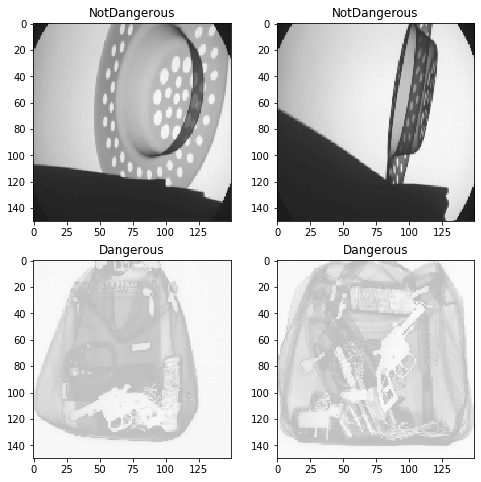

In [25]:
image_per_class = 2
classes = os.listdir(train_data_dir)
subplot = len(classes)*100 + image_per_class*10 + 1
fig = plt.figure(figsize=(8,8))
for each_class in classes:
    files = os.listdir(os.path.join(train_data_dir, each_class))
    files_to_print = random.sample(files, image_per_class)
    for image_file in files_to_print:
        img = image.load_img(os.path.join(train_data_dir, each_class, image_file), target_size=(150,150))
        plt.subplot(subplot)
        plt.imshow(img)
        plt.title(each_class)
        subplot += 1
plt.show()

In [23]:
rescale = 1./255
target_size = (150, 150)
batch_size = 16
class_mode = "categorical"
#class_mode = "binary"

train_datagen = ImageDataGenerator(rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 296 images belonging to 2 classes.
Found 73 images belonging to 2 classes.


In [8]:
# Checkpoint
model_dir = 'models'
model_file = model_dir + '/detectx-mobilenet-{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='acc',
    period=1)

callbacks = [checkpoint]

In [25]:
def get_mobilenet():
    base_mobilenet_model = MobileNet(
        input_shape=(150, 150, 3), 
        include_top=False,
        weights=None
    )
    model = Sequential()
    model.add(base_mobilenet_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model

In [26]:
optimizer = Adam(lr=0.001)
# For more than two classes use categorical_crossentropy or sparse_categorical_crossentropy
loss = 'categorical_crossentropy'
metrics = ['accuracy']
steps_per_epoch = 19
validation_steps = 5
epochs = 50

In [27]:
model = get_mobilenet()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_150 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 3,754,690
Trainable params: 3,732,802
Non-trainable params: 21,888
_______________________________________

In [10]:
epochs = 50
history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    epochs=epochs,
    callbacks = callbacks,
  verbose=1)

W1009 20:26:07.300517 140070466869056 deprecation.py:323] From /home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
19/19 [==============================] - 30s 2s/step - loss: 0.2270 - acc: 0.9242 - val_loss: 7.9486 - val_acc: 0.5068
Epoch 2/50
19/19 [==============================] - 26s 1s/step - loss: 0.2168 - acc: 0.9639 - val_loss: 7.9487 - val_acc: 0.5068
Epoch 3/50
19/19 [==============================] - 27s 1s/step - loss: 0.0011 - acc: 1.0000 - val_loss: 7.9486 - val_acc: 0.5068
Epoch 4/50
19/19 [==============================] - 27s 1s/step - loss: 0.0386 - acc: 0.9936 - val_loss: 7.9486 - val_acc: 0.5068
Epoch 5/50
19/19 [==============================] - 29s 2s/step - loss: 0.1562 - acc: 0.9769 - val_loss: 7.9486 - val_acc: 0.5068
Epoch 6/50
19/19 [==============================] - 30s 2s/step - loss: 0.2452 - acc: 0.9605 - val_loss: 7.9486 - val_acc: 0.5068
Epoch 7/50
19/19 [==============================] - 27s 1s/step - loss: 0.1301 - acc: 0.9736 - val_loss: 7.9487 - val_acc: 0.5068
Epoch 8/50
19/19 [==============================] - 30s 2s/step - loss: 0.1081 - acc: 0.98

Clearly the model at 40th epoch is performing the best in terms of validation loss and accuracy.<br>
Lets load this model...

In [26]:
from keras.models import load_model

In [28]:
model_epoch = load_model('models/detectx-mobilenet-40.hdf5')
model_epoch.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_150 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 3,754,690
Trainable params: 3,732,802
Non-trainable params: 21,888
_______________________________________

In [31]:
y_pred = model_epoch.predict_generator(validation_generator)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

[0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0
 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1]


Now, lets validate the model

In [33]:
y_true = validation_generator.classes
y_true = y_true.reshape((y_true.shape[0], 1))
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44        36
           1       0.46      0.46      0.46        37

    accuracy                           0.45        73
   macro avg       0.45      0.45      0.45        73
weighted avg       0.45      0.45      0.45        73



Due to sparsity of data, the performance of the model is bad. To improve this we are trying to gather more data.